# Document and Image Analysis with Amazon Nova Models

In this notebook, we demonstrate how to leverage Amazon Nova models along with the AWS Bedrock Converse API for Intelligent Document Processing (IDP) and joing image analysis. Our goal is to extract both unstructured summaries and structured data from PDF insurance claims forms. We cover several use cases:

- **Summarizing Content:** Extracting a brief summary and key insights from one claims form
- **Structured Data Extraction:** Using a custom tool configuration to force the model to output structured data from froms that follow the same layout.
- **Integrate Image Analysis:** Using Nova image analysis to validate claims are legimate by auditing how closely provided images align with data on the associated claims document
- **Generating Business Insights:** Aggregating data from multiple claims forms and provided images to answer specific business questions.

This notebook assumes you are running the code with proper AWS credentials (preferably using an IAM role) and that you have enabled Amazon Bedrock models (in us-west-2) in your account. For more details on setting up temporary AWS credentials and enabling models, please refer to the provided documentation links.

**Notes:**
- Make sure you are running this code using your AWS Credentials. This notebook assumes you are loading the credentials using an IAM role, however, you may use your access_key if you are not using IAM Roles. For more details about how to set temporaty AWS credentials please check [this link](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_temp_use-resources.html).
- Before using Amazon Bedrock models in this notebook you need to enable them in your account in us-west-2, for more details about the steps required to enabled the model please check [this link](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access-modify.html).
- This notebook uses Amazon Nova Pro as default, all [charges on-demand on request basis](https://aws.amazon.com/bedrock/pricing/).
- Amazon Nova Pro will be used with the [Cross-Region Inference mode](https://docs.aws.amazon.com/bedrock/latest/userguide/cross-region-inference.html).
- While this notebook uses us-west-2 (Oregon), Amazon Nova is available in a variety of AWS Regions. Check our [document pages](https://docs.aws.amazon.com/bedrock/latest/userguide/models-regions.html) for more details about the regions available.

## Setup

Lets import our modules:

<div class="alert alert-info">
 <b>You will see pip dependency errors, you can safely ignore these errors.</b>
    
    IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
</div>

In [1]:
%pip install --upgrade -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import sagemaker
import logging
from IPython.display import IFrame
from IPython.display import display, Image
from botocore.exceptions import ClientError
from pprint import pprint
import json
import os
from glob import glob

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
logging.basicConfig(level=logging.INFO,
                        format="%(levelname)s: %(message)s")

In [4]:
# Get the region from the SageMaker session
region_name = sagemaker.Session().boto_region_name
print(f"Current AWS Region: {region_name}")

Current AWS Region: us-east-1


In [5]:
MICRO_MODEL_ID = "us.amazon.nova-micro-v1:0"
LITE_MODEL_ID = "us.amazon.nova-lite-v1:0"
PRO_MODEL_ID = "us.amazon.nova-pro-v1:0"
PREMIER_MODEL_ID = "us.amazon.nova-premier-v1:0"

## 1. Summarize Content: Extracting a brief summary and key insights from one claims file
In this use case we will use Amazon Nova models to process and extract data from PDF insurance claims forms  for damaged cell phones using the Bedrock Converse API.

Here is our help function to load pdf and send requests to Amazon Bedrock using **Amazon Nova Pro**.

In [6]:
def send_document_to_bedrock(prompt, model_id=PRO_MODEL_ID, file_path=None, tool_config=None, document_type=None):
    """
    Sends a message to the AWS Bedrock Converse API for processing, optionally including a PDF document.
    This function constructs a message that includes a text prompt and, if provided, a PDF document (as raw bytes)
    read from the specified file system path. It then sends the message to the AWS Bedrock Converse API using the provided
    model ID. Optionally, if a tool configuration is provided via the `tool_config` parameter, it is passed to the API call.
    The API response, which includes the model's output message and associated metadata, is returned.
    Parameters:
        prompt (str): A text prompt that provides context or instructions for processing.
        model_id (str): The identifier of the AWS Bedrock model to use for inference. This model must support document
            inputs. If no model_id is provided, Amazon Nova Pro will be used.
        file_path (str, optional): The file system path to the PDF document. If provided, the PDF will be read and
            included in the message. Defaults to None.
        tool_config (dict, optional): A dictionary specifying the tool configuration to be passed to the Converse API.
            Defaults to None.
        document_type (str): Document type, e.g., pdf, png.
    Returns:
        dict or None: The JSON response from the Bedrock Converse API if the call is successful, containing the model's
        output and metadata; returns None if an error occurs.
    Raises:
        ClientError: If there is an error invoking the AWS Bedrock Converse API.
    """
    # Build the content list starting with the prompt
    content_blocks = [{"text": prompt}]
    # If a PDF file path is provided, read the file and add a document block
    if file_path is not None:
        with open(file_path, "rb") as f:
            doc_bytes = f.read()
        if document_type == "pdf":
            content_blocks.append({
                "document": {
                    "name": "claim_template",  # Use a neutral name
                    "format": "pdf",  # Supported formats: pdf | csv | doc | docx | xls | xlsx | html | txt | md
                    "source": {
                        "bytes": doc_bytes
                    }
                }
            })
        elif document_type == "png":
            content_blocks.append({
                "image": {
                    "format": "png",
                    "source": {"bytes": doc_bytes},
                }
            })
    # Initialize the Bedrock runtime client
    # Note: 'region_name' should be defined or replaced with your desired AWS region
    bedrock_client = boto3.client("bedrock-runtime", region_name=region_name)
    # Construct the message with the content blocks
    message = {
        "role": "user",
        "content": content_blocks
    }
    # Optional inference configuration parameters
    inference_config = {
        "maxTokens": 3000,
        "temperature": 0
    }
    try:
        # Build the parameters for the converse call
        converse_params = {
            "modelId": model_id,
            "messages": [message],
            "inferenceConfig": inference_config
        }
        # Include toolConfig if provided
        if tool_config is not None:
            converse_params["toolConfig"] = tool_config
        # Call the Converse API with the constructed parameters
        response = bedrock_client.converse(**converse_params)
        return response
    except ClientError as e:
        print("An error occurred:", e)
        return None

Here is a view of a sample pdf:

In [7]:
pdf_path = "documents/claim-form-001.pdf"
IFrame(pdf_path, width=600, height=900)

Lets extract a summary from the claim form:

In [8]:
prompt_text = "Please summarize the content of this PDF. Provide your output in a bullet point list"

result = send_document_to_bedrock(prompt=prompt_text, file_path=pdf_path, document_type="pdf")
if result:
    # Extract and print the text response from the model
    output_message = result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "text" in content:
            print(content["text"])

 - The generated text has been blocked by our content filters.


## 2. Structured Data Extraction: Using a custom tool configuration to force the model to output structured data from invoices that follow the same layout
Amazon Nova Pro was able to extract all the information present in our sample invoice. However, let’s improve our workflow by extracting data from our invoices using a custom blueprint and producing structured output. For this approach, we will use a custom tool, which is ideal if you need to force your model to produce structured output. In this sample code, we assume that all claim forms follow the same layout; however, you can modify the prompts to dynamically extract data as well. First, we'll define a custom tool called "claim_data_tool" that extracts structured damage claim information from a form. The tool specifies properties for claim information, customer information, device information, insurance coverage, and incident details.

In [9]:
claim_data_tool = {
    "tools": [{
        "toolSpec": {
            "name": "extract_claim_info",
            "description": "Extracts structured information from damage insurance claim documents",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "claim_information": {
                            "type": "object",
                            "description": "Basic claim identification and status details",
                            "properties": {
                                "claim_number": {"type": "string"},
                                "claim_date": {"type": "string", "format": "date"},
                                "claim_status": {"type": "string"}
                            }
                        },
                        "customer_information": {
                            "type": "object",
                            "description": "Customer contact and identification details",
                            "properties": {
                                "customer_name": {"type": "string"},
                                "account_number": {"type": "string"},
                                "phone_number": {"type": "string"},
                                "email_address": {"type": "string"},
                                "customer_address": {"type": "string"}
                            }
                        },
                        "device_information": {
                            "type": "object",
                            "description": "Details about the insured device",
                            "properties": {
                                "phone_make": {"type": "string"},
                                "phone_model": {"type": "string"},
                                "color": {"type": "string"},
                                "storage_capacity_gb": {"type": "integer"},
                                "imei_number": {"type": "string"},
                                "serial_number": {"type": "string"},
                                "date_of_purchase": {"type": "string", "format": "date"},
                                "place_of_purchase": {"type": "string"}
                            }
                        },
                        "insurance_coverage": {
                            "type": "object",
                            "description": "Insurance policy and coverage details",
                            "properties": {
                                "insurance_plan": {"type": "string"},
                                "policy_number": {"type": "string"},
                                "monthly_premium": {"type": "number"},
                                "deductible_amount": {"type": "number"},
                                "coverage_start_date": {"type": "string", "format": "date"}
                            }
                        },
                        "incident_details": {
                            "type": "object",
                            "description": "Information about the damage incident",
                            "properties": {
                                "date_of_damage": {"type": "string", "format": "date"},
                                "time_of_incident": {"type": "string"},
                                "location_of_incident": {"type": "string"},
                                "damage_description": {"type": "string"},
                                "type_of_damage": {"type": "string"}
                            }
                        }
                    },
                    "required": [
                        "claim_information",
                        "customer_information",
                        "device_information",
                        "insurance_coverage",
                        "incident_details"
                    ]
                }
            }
        }
    }],
    "toolChoice": {"auto": {}}
}


It is time to use our `send_document_to_bedrock` function again but this time adding our new tool.

In [10]:
prompt_text = "Please summarize the content of this PDF and share your insights."
# Document list
document_list = []

# Lets create another helper functions
def update_document_list(prompt, file_path, tools, document_type, document_list):
    """
    This function updates the document list by sending the prompt and file path to the Bedrock model.
    It then extracts the toolUse input from the model's response and appends it to the document list.

    Args:
        prompt (str): The prompt to be sent to the Bedrock model.
        file_path (str): The path to the file to be sent to the Bedrock model.
        tools (str): The tools configuration for the Bedrock model.
        document_type (str): The type of document being processed.
        document_list (list): The list to which the extracted toolUse input will be appended.

    Returns:
        None
    """
    result = send_document_to_bedrock(
        prompt=prompt,
        file_path=file_path,
        tool_config=claim_data_tool, #add defined tool here
        document_type=document_type)
    if result:
        # Extract and print the text response from the model
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "toolUse" in content:
                pprint(content["toolUse"]["input"])
                # We will store the extracted information in our list
                document_list.append(content["toolUse"]["input"])

update_document_list(prompt=prompt_text, 
                     file_path=pdf_path, 
                     tools=claim_data_tool, 
                     document_type="pdf", 
                     document_list=document_list)

{'claim_information': {'claim_date': '2024-03-15',
                       'claim_number': 'CLM-2024-089472',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-558-9234-01',
                          'customer_address': '1247 Maple Street, Apt 3B, '
                                              'Seattle, WA 98102',
                          'customer_name': 'Sarah Mitchell',
                          'email_address': 'sarah.mitchell@email.com',
                          'phone_number': '(555) 234-8901'},
 'device_information': {'color': 'Gold',
                        'date_of_purchase': '2023-10-12',
                        'imei_number': '356728491038562',
                        'phone_make': 'Apple',
                        'phone_model': 'iPhone 14 Pro',
                        'place_of_purchase': 'AnyCom Telecom Store - Seattle '
                                             'Downtown',
                        'serial_number

We will now extract the information from a second document using the same tool created by Nova, and add the document to our list.

In [11]:
# View the second claim
pdf_path="documents/claim-form-002.pdf"
IFrame(pdf_path, width=600, height=900)


In [12]:
# Extract information from the second claim using the tool
update_document_list(prompt=prompt_text, file_path=pdf_path, tools=claim_data_tool, document_type="pdf", document_list=document_list)

{'claim_information': {'claim_date': '2024-03-18',
                       'claim_number': 'CLM-2024-089573',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-742-3381-09',
                          'customer_address': '892 Oak Boulevard, Unit 12, '
                                              'Portland, OR 97201',
                          'customer_name': 'Marc Thompson',
                          'email_address': 'm.thompson.2024@email.com',
                          'phone_number': '(555) 891-2347'},
 'device_information': {'color': 'Titanium Black',
                        'date_of_purchase': '2024-03-02',
                        'imei_number': '352847109382761',
                        'phone_make': 'Samsung',
                        'phone_model': 'Galaxy S24 Ultra',
                        'place_of_purchase': 'AnyCompany Telecom Store - '
                                             'Portland Mall',
                    

We have two documents in our list now:

In [13]:
print(f'Document count: {len(document_list)}')

Document count: 2


## 3. Integrate Image Analysis: Validate data extracted from pdf files with associated images
We have used Amazon Nova to create a custom blueprint using a tool for the Converse API and also extracted data from 2 documents using the same blueprint. We use the information extracted from the tool to validate that claim data aligns with associated images submitted as proof of damage. Since this task represents a sort of audit, we will use Amazon Nova Premier for higher intelligence to validate details in the images againt details of the claims. 

Let's take a look at the associated image for the first claim document:

Damage Photo Evidence:


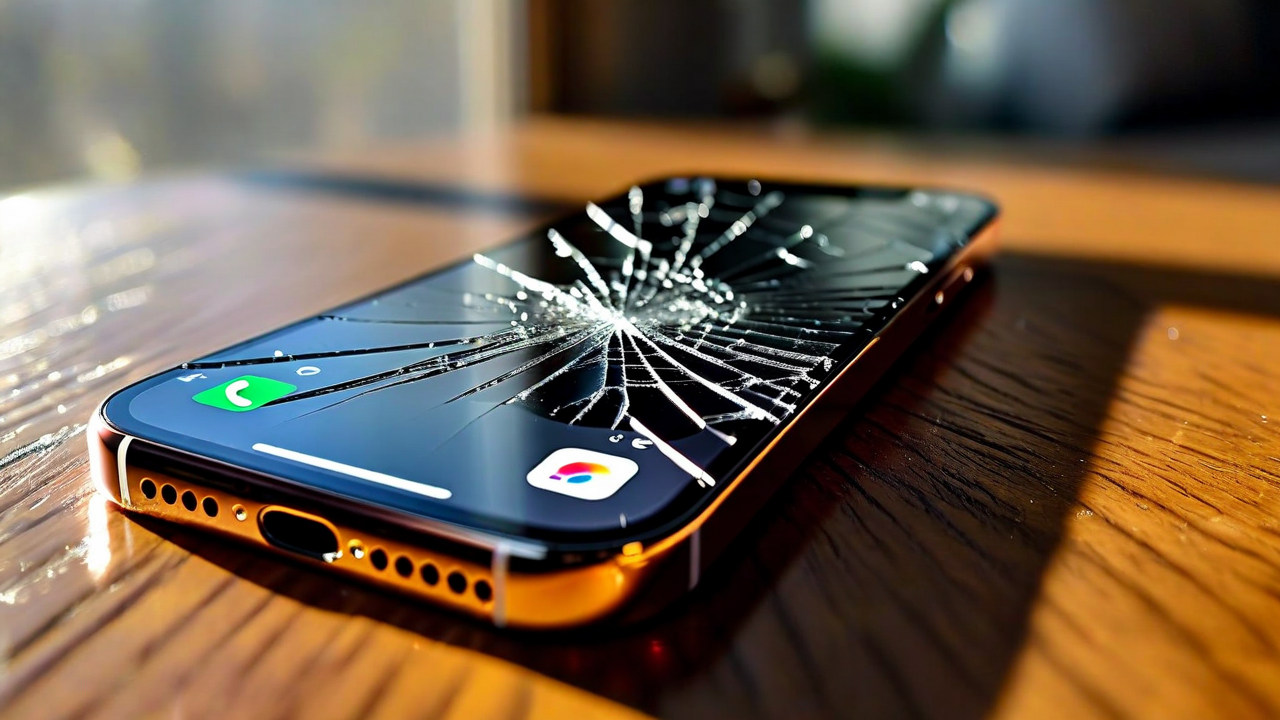

In [14]:
# Path to the damage photo
photo_path = "images/phone-001.png"

# Display the image
print("Damage Photo Evidence:")
display(Image(filename=photo_path, width=600))  # Adjust width as needed for clear visibility


Now let's use the data extracted from the claim form to validate that the damage claim described aligns with the associated image provided as proof of damage

In [15]:
#define image validation function
def validate_claim_with_photo(claim_data, photo_path):
    # Create a tool config to force structured output
    tool_config = {
        "tools": [{
            "toolSpec": {
                "name": "claim_validation",
                "description": "Validate insurance claim by comparing photo evidence against claim details",
                "inputSchema": {
                    "json": {
                        "type": "object",
                        "properties": {
                            "device_identification": {
                                "type": "object",
                                "properties": {
                                    "value": {"type": "string", "enum": ["true", "false", "unclear"]},
                                    "rationale": {"type": "string"}
                                },
                                "required": ["value", "rationale"]
                            },
                            "damage_verification": {
                                "type": "object",
                                "properties": {
                                    "value": {"type": "string", "enum": ["true", "false", "unclear"]},
                                    "rationale": {"type": "string"}
                                },
                                "required": ["value", "rationale"]
                            },
                            "incident_consistency": {
                                "type": "object",
                                "properties": {
                                    "value": {"type": "string", "enum": ["true", "false", "unclear"]},
                                    "rationale": {"type": "string"}
                                },
                                "required": ["value", "rationale"]
                            },
                            "fraud_risk_score": {
                                "type": "object",
                                "properties": {
                                    "value": {"type": "number", "minimum": 0, "maximum": 1},
                                    "rationale": {"type": "string"}
                                },
                                "required": ["value", "rationale"]
                            },
                            "inconsistencies_detected": {
                                "type": "object",
                                "properties": {
                                    "value": {"type": "string", "enum": ["true", "false"]},
                                    "rationale": {"type": "string"}
                                },
                                "required": ["value", "rationale"]
                            },
                            "recommended_action": {
                                "type": "string",
                                "enum": ["pass to next step", "human review needed"]
                            }
                        },
                        "required": [
                            "device_identification",
                            "damage_verification",
                            "incident_consistency",
                            "fraud_risk_score",
                            "inconsistencies_detected",
                            "recommended_action"  # Added to required fields
                        ]
                    }
                }
            }
        }],
        "toolChoice": {"auto": {}}
    }

    prompt_text = f"""
    Analyze this damage photo against the claim details to provide a structured validation assessment.
    Based on the following criteria, determine if the claim should pass to next step or needs human review:
    - If fraud_risk_score > 0.5, recommend human review
    - If any inconsistencies are detected, recommend human review
    - If device_identification or damage_verification is false, recommend human review
    - Otherwise, pass to next step

    Claim Details:
    - Device: {claim_data['device_information']['phone_make']} {claim_data['device_information']['phone_model']}
    - Color: {claim_data['device_information']['color']}
    - Storage: {claim_data['device_information']['storage_capacity_gb']}GB
    - IMEI: {claim_data['device_information']['imei_number']}
    
    Reported Incident:
    - Damage Type: {claim_data['incident_details']['type_of_damage']}
    - Description: {claim_data['incident_details']['damage_description']}
  

    For each assessment category, provide a clear, single-sentence rationale explaining your judgment.
    You MUST include a recommended_action based on the criteria above.
    """

    result = send_document_to_bedrock(
        prompt=prompt_text,
        model_id=PREMIER_MODEL_ID,
        file_path=photo_path,
        document_type="png",
        tool_config=tool_config
    )
    
    return result

In [16]:
#define claim path using previous extracted data
claim_data = document_list[0]

# Run validation
validation_result = validate_claim_with_photo(claim_data, photo_path)

if validation_result:
    output_message = validation_result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "toolUse" in content:
            print("\nValidation Results:")
            pprint(content["toolUse"]["input"])


Validation Results:
{'damage_verification': {'rationale': 'Visible extensive spider-web cracking '
                                      'matches reported accidental drop damage',
                         'value': 'true'},
 'device_identification': {'rationale': 'Photo shows gold iPhone 14 Pro with '
                                        'Face ID notch and triple cameras '
                                        'matching claim details',
                           'value': 'true'},
 'fraud_risk_score': {'rationale': 'Damage pattern consistent with reported '
                                   'incident type and device model',
                      'value': 0.2},
 'incident_consistency': {'rationale': 'Crack pattern aligns with high-impact '
                                       'drop scenario described',
                          'value': 'true'},
 'inconsistencies_detected': {'rationale': 'No discrepancies between photo '
                                           'evidence and cl

### Batch Analysis: Process claims and images in batch mode (OPTIONAL)

Now we will process all claim forms we have and their associate images in batch mode. We currently have 3 claim forms and associated images that we will analyze in batch mode.


Processing Claim 1:

Damage Photo for Claim 1:


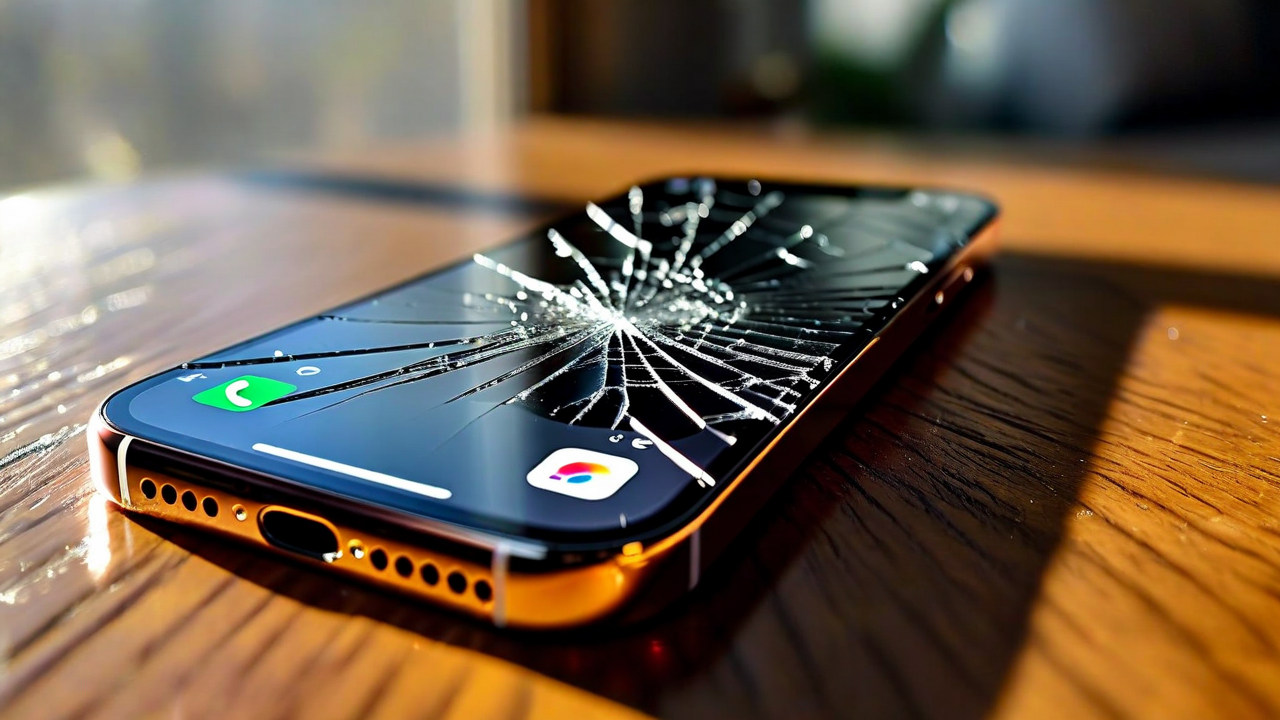


Claim Form Data 1:
{'claim_information': {'claim_date': '2024-03-15',
                       'claim_number': 'CLM-2024-089472',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-558-9234-01',
                          'customer_address': '1247 Maple Street, Apt 3B, '
                                              'Seattle, WA 98102',
                          'customer_name': 'Sarah Mitchell',
                          'email_address': 'sarah.mitchell@email.com',
                          'phone_number': '(555) 234-8901'},
 'device_information': {'color': 'Gold',
                        'date_of_purchase': '2023-10-12',
                        'imei_number': '356728491038562',
                        'phone_make': 'Apple',
                        'phone_model': 'iPhone 14 Pro',
                        'place_of_purchase': 'AnyCom Telecom Store - Seattle '
                                             'Downtown',
                  

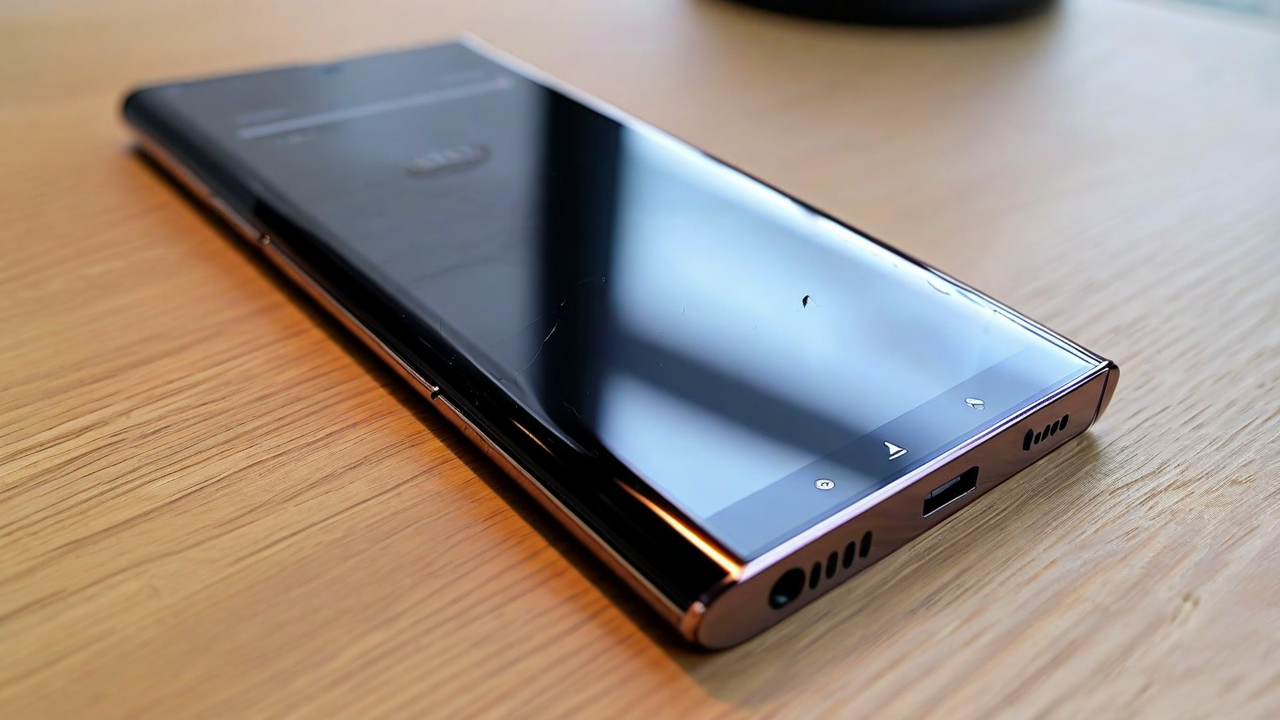


Claim Form Data 2:
{'claim_information': {'claim_date': '2024-03-18',
                       'claim_number': 'CLM-2024-089573',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-742-3381-09',
                          'customer_address': '892 Oak Boulevard, Unit 12, '
                                              'Portland, OR 97201',
                          'customer_name': 'Marc Thompson',
                          'email_address': 'm.thompson.2024@email.com',
                          'phone_number': '(555) 891-2347'},
 'device_information': {'color': 'Titanium Black',
                        'date_of_purchase': '2024-03-02',
                        'imei_number': '352847109382761',
                        'phone_make': 'Samsung',
                        'phone_model': 'Galaxy S24 Ultra',
                        'place_of_purchase': 'AnyCompany Telecom Store - '
                                             'Portland Mall',


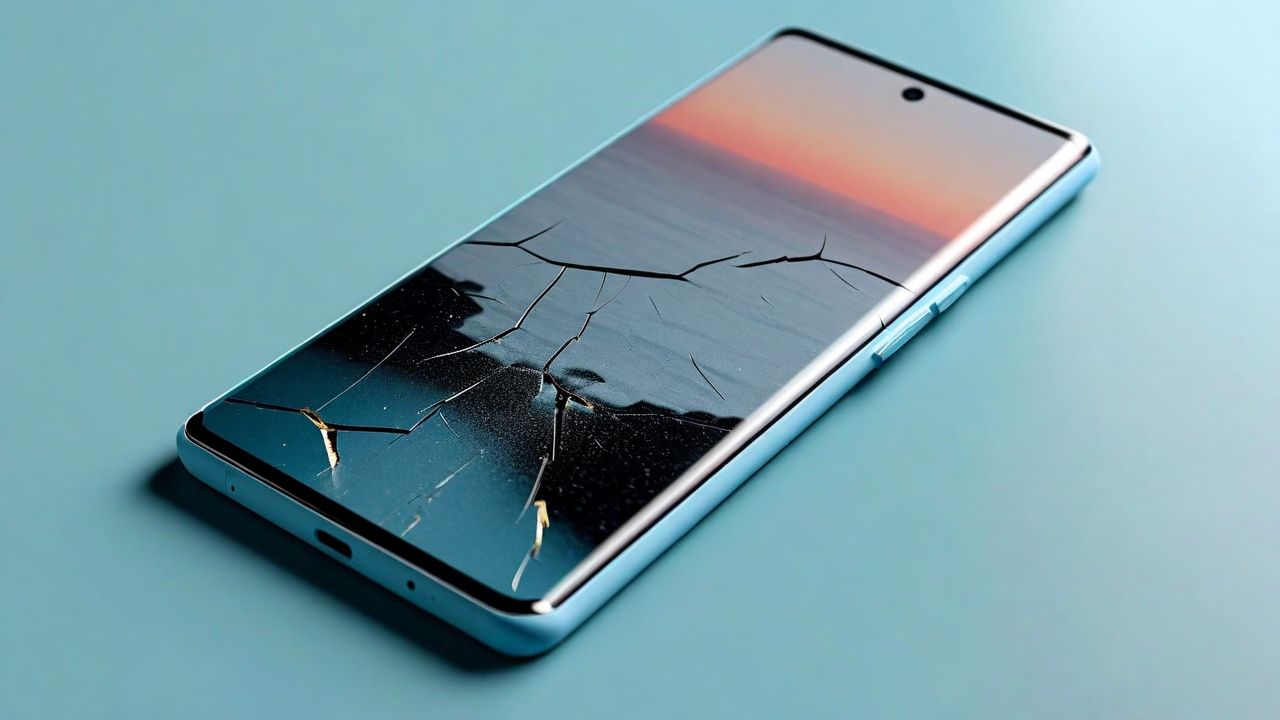


Claim Form Data 3:
{'claim_information': {'claim_date': '2024-03-20',
                       'claim_number': 'CLM-2024-089681',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-429-7156-03',
                          'customer_address': '3456 Riverside Drive, Suite '
                                              '201, Austin, TX 78704',
                          'customer_name': 'Jennifer Park',
                          'email_address': 'jennifer.park@corporatemail.com',
                          'phone_number': '(555) 672-4903'},
 'device_information': {'color': 'Bay Blue',
                        'date_of_purchase': '2023-08-05',
                        'imei_number': '358920117638492',
                        'phone_make': 'Google',
                        'phone_model': 'Pixel 8 Pro',
                        'place_of_purchase': 'AnyCompany Telecom Store - '
                                             'Austin Central',
  

In [17]:
def batch_process_claims():
    # Lists to store processed data
    all_claims = []
    all_validations = []
    
    # Process each claim form and its associated image
    for i in range(1, 4):  # We have forms 1-3
        # Paths for current claim
        claim_path = f"documents/claim-form-00{i}.pdf"
        photo_path = f"images/phone-00{i}.png"
        
        print(f"\nProcessing Claim {i}:")
        print("=====================================")
        
        # Display the claim photo
        print(f"\nDamage Photo for Claim {i}:")
        display(Image(filename=photo_path, width=600))
        
        # Extract claim data
        prompt_text = "Please extract structured data from this claim form."
        result = send_document_to_bedrock(
            prompt=prompt_text,
            file_path=claim_path,
            document_type="pdf",
            tool_config=claim_data_tool  # Using the previously defined tools config
        )
        
        if result:
            claim_data = None
            output_message = result.get("output", {}).get("message", {})
            for content in output_message.get("content", []):
                if "toolUse" in content:
                    claim_data = content["toolUse"]["input"]
                    all_claims.append(claim_data)
                    print(f"\nClaim Form Data {i}:")
                    pprint(claim_data)
        
            # If we successfully extracted claim data, validate with photo
            if claim_data:
                print(f"\nValidating Claim {i} against photo evidence:")
                validation_result = validate_claim_with_photo(claim_data, photo_path)
                
                if validation_result:
                    output_message = validation_result.get("output", {}).get("message", {})
                    for content in output_message.get("content", []):
                        if "toolUse" in content:
                            validation_data = content["toolUse"]["input"]
                            all_validations.append({
                                "claim_number": claim_data["claim_information"]["claim_number"],
                                "validation": validation_data
                            })
                            print("\nValidation Results:")
                            pprint(validation_data)
    
    # Generate summary report
    print("\nBatch Processing Summary:")
    print("=====================================")
    print(f"Total Claims Processed: {len(all_claims)}")
    print(f"Total Validations Completed: {len(all_validations)}")
    
    # Print fraud risk assessment summary
    print("\nFraud Risk Assessment Summary:")
    for validation in all_validations:
        print(f"\nClaim {validation['claim_number']}:")
        print(f"Fraud Risk Score: {validation['validation']['fraud_risk_score']['value']}")
        print(f"Recommended Action: {validation['validation']['recommended_action']}")
    
    return all_claims, all_validations

# Run batch processing
processed_claims, validation_results = batch_process_claims()

## 4. Generate Business Insights: Aggregating data from multiple claims forms and images to answer specific business questions (OPTIONAL)
We have used Amazon Nova to create a custom blueprint using a tool for the Converse API and also extracted data from multiple documents using the same blueprint. We have also analysed associate images provided for the documents. We begin with the following questions: 
1. What percentage of claims show damage types that match between photos and descriptions?
2. What is the average fraud risk score across all claims?

You can add other questions as interested

In [18]:
def analyze_damage_claims():
    user_questions = """
    Based on both claim forms and damage photos:
    1. What percentage of claims show damage types that match between photos and descriptions?
    2. What is the average fraud risk score across all claims?
    """

    prompt_extracting_insights = f"""
    You are a telecom insurance analyst. Looking at both the claim form data and photo evidence:
    - Focus on damage type verification between photos and descriptions
    - Consider the severity of damage across different phone models
    - Identify the strongest fraud indicators from photo/claim mismatches
    - Keep your response clear and concise with no preamble
    - Think step by step


    Questions: {user_questions}
    Claims and photos data: {validation_results}
    """

    result = send_document_to_bedrock(
        prompt=prompt_extracting_insights,
        model_id=PRO_MODEL_ID
    )

    if result:
        print("\nDamage Claims Analysis:")
        print("=======================")
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "text" in content:
                print(content["text"])

# Run the analysis
analyze_damage_claims()



Damage Claims Analysis:
1. **Percentage of claims with matching damage types**: 33.3% (1 out of 3 claims show matching damage types between photos and descriptions).
2. **Average fraud risk score**: 0.5 ((0.3 + 0.6 + 0.6) / 3).


# Conclusion

In this notebook, we demonstrated the practical application of Amazon Nova models for intelligent document processing and image analysis in an insurance claims context:

## Key Learnings

1. **Document Understanding and Data Extraction**
   - Extracted structured data from PDF claim forms using custom tool configurations
   - Demonstrated batch processing capabilities across multiple claim documents 
   - Leveraged Nova's ability to convert unstructured form data into structured JSON outputs

2. **Multimodal Validation**
   - Implemented photo evidence validation against claim form data
   - Created a structured validation framework with specific assessment criteria
   - Demonstrated Nova's ability to compare textual descriptions with visual evidence

3. **Business Insights Generation**
   - Combined form data and photo analysis for comprehensive claim assessment
   - Generated actionable insights about damage patterns and fraud indicators
   - Showcased how multimodal analysis can enhance decision-making in insurance processing


This implementation shows how Amazon Nova can be used to create practical,enterprise solutions for multimodal processing and validation tasks